The objective of this assignment is to build a convolutionary network 
the data set contains the image of cats and dogs here model try to learn the features of these image and able to classify unseen
images correctly and efficiently.

About Dataset

Data source: The data set has been taken from Kaggle which contains Training and Test sets with 25000 & 12500 images of equal number of cats & dogs respectively. But, we are going to use only few images (2000) to build the model.


1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text. Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sivarangareddy","key":"62ed8f6d9f3f2dfad8ec20fd5aaf9d05"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 23.9MB/s]
100% 812M/812M [00:35<00:00, 23.9MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Using `image_dataset_from_directory` to read images**

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Data preprocessing

In [9]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [10]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [11]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [12]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [13]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Displaying the shapes of the data and labels yielded by the `Dataset`**

**Fitting the model using a `Dataset`**

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 81ms/step - loss: 0.6946 - accuracy: 0.5190 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6934 - accuracy: 0.5090 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6726 - accuracy: 0.5835 - val_loss: 0.6329 - val_accuracy: 0.6490
Epoch 4/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6467 - accuracy: 0.6265 - val_loss: 0.6253 - val_accuracy: 0.6460
Epoch 5/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6236 - accuracy: 0.6510 - val_loss: 0.6052 - val_accuracy: 0.6560
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6109 - accuracy: 0.6685 - val_loss: 0.5932 - val_accuracy: 0.6830
Epoch 7/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5976 - accuracy: 0.6715 - val_loss: 0.5724 - val_accuracy: 0.7080
Epoch 8/30
6

**Displaying curves of loss and accuracy during training**

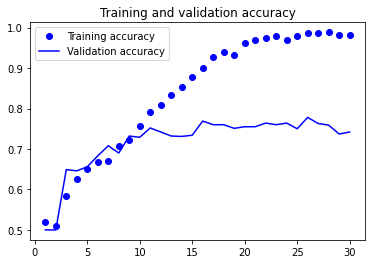

<Figure size 432x288 with 0 Axes>

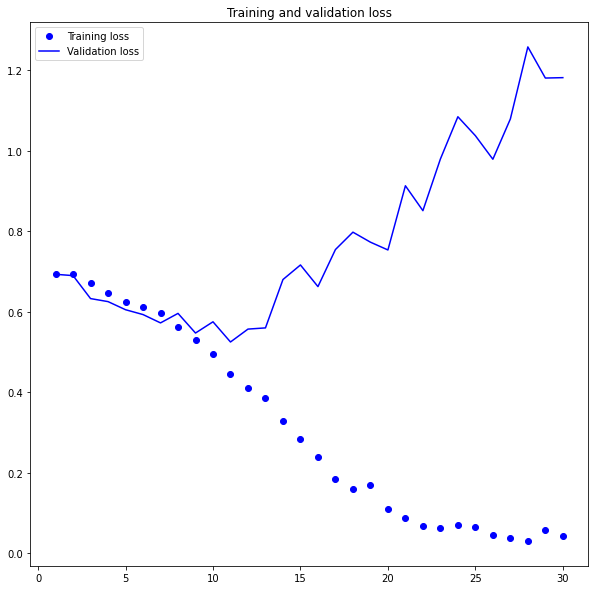

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.5491 - accuracy: 0.7390
Test accuracy: 0.739


from the result we can see that 
we took the validation and train accuracy values from the epoch (26) where we can sudden drop in validation accuracy of 27 eppoach 
Test Accuracy - 73.9%
Train Accuracy - 98.70%
validation accuracy-76.30%
all the above result are based on 
training sample  1000 
valiadtion 500
test 500

Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [20]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

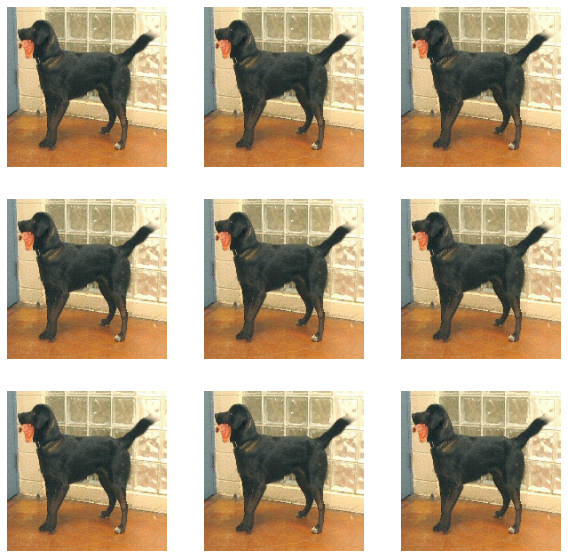

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 103ms/step - loss: 0.6951 - accuracy: 0.4935 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 2/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6893 - val_accuracy: 0.5450
Epoch 3/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6906 - accuracy: 0.5400 - val_loss: 0.6992 - val_accuracy: 0.5020
Epoch 4/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6903 - accuracy: 0.5320 - val_loss: 0.6920 - val_accuracy: 0.5410
Epoch 5/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6886 - accuracy: 0.5380 - val_loss: 0.6775 - val_accuracy: 0.5940
Epoch 6/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6851 - accuracy: 0.5520 - val_loss: 0.6749 - val_accuracy: 0.5890
Epoch 7/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6785 - accuracy: 0.5760 - val_loss: 0.6748 - val_accuracy: 0.5690
Epoch 8/50
6

**Evaluating the model on the test set**

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 34ms/step - loss: 0.4571 - accuracy: 0.8130
Test accuracy: 0.813


# from the result we can see that 
we took the validation and train accuracy values from the epoch (48) where we can sudden drop in validation accuracy of 49 eppoach

Test Accuracy - 81.30
Train Accuracy - 87.60
validation accuracy-82.0
all the above result are based on 
training sample  1500 
valiadtion 500
test 500


 from the above result we can say that we got  better results from earlier due to following reasons

1.we have increased the training data points from 1000 to 1500

2.since using of data augmentation  we are able to redudce the overfit if we see earlier we got train accuracy as 97% but using of data augmentation it able to reduce overfit ended up with an % of 87%

3.moreover data augmentation also helped to generalise the model with better accuracy 


Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Increasing the training sample to 2000, keeping the Validation and test sets the same as before(500 samples)

In [26]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

Defining a new convnet with increased training samples,image augmentation and dropout

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 103ms/step - loss: 0.6943 - accuracy: 0.5285 - val_loss: 0.6896 - val_accuracy: 0.5910
Epoch 2/50
63/63 [==============================] - 6s 91ms/step - loss: 0.6940 - accuracy: 0.5045 - val_loss: 0.6917 - val_accuracy: 0.5310
Epoch 3/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6879 - accuracy: 0.5415 - val_loss: 0.6715 - val_accuracy: 0.5760
Epoch 4/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6724 - accuracy: 0.6010 - val_loss: 0.6716 - val_accuracy: 0.5880
Epoch 5/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6481 - accuracy: 0.6380 - val_loss: 0.6610 - val_accuracy: 0.6110
Epoch 6/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6428 - accuracy: 0.6365 - val_loss: 0.6351 - val_accuracy: 0.6470
Epoch 7/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6134 - accuracy: 0.6640 - val_loss: 0.6149 - val_accuracy: 0.6470
Epoch 8/50
6

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.4262 - accuracy: 0.8080
Test accuracy: 0.808


we took the validation and train accuracy values from the epoch (44) where we can sudden drop in validation accuracy of 45 eppoach

Test Accuracy - 80.80
Train Accuracy - 87.20
validation accuracy-85.30
all the above result are based on 
training sample  2000
valiadtion 500
test 500

As we know data augmentation prevents the model from overfitting. some augmentation combinations can actually lead to underfitting  Moreover, the model is not able to learn as much information to give accurate predictions which, again leads to reduce the accuracy from this we can say that same thing  

Eevnthough we have increased the data points with data augmentation we still not able to get the best result compared to earlier 

Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 19.3442 - accuracy: 0.9225 - val_loss: 24.0043 - val_accuracy: 0.8780
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 2.9299 - accuracy: 0.9775 - val_loss: 4.8983 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.5137 - accuracy: 0.9840 - val_loss: 5.2411 - val_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.5100 - accuracy: 0.9895 - val_loss: 6.3511 - val_accuracy: 0.9640
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3685 - accuracy: 0.9905 - val_loss: 5.0639 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3226 - accuracy: 0.9955 - val_loss: 4.2516 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.7978 - accuracy: 0.9945 - val_loss: 3.8098 - val_accuracy: 0.9820
Epoch 8/20
63/63 

**Plotting the results**

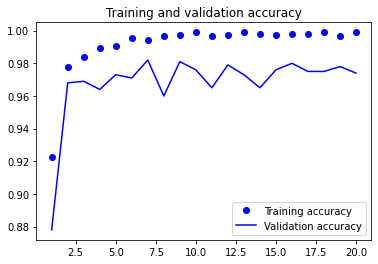

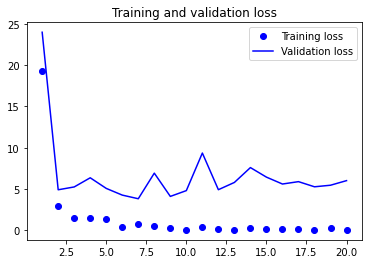

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [37]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 204ms/step - loss: 17.3001 - accuracy: 0.8980 - val_loss: 9.7166 - val_accuracy: 0.9330
Epoch 2/50
63/63 [==============================] - 14s 226ms/step - loss: 7.4549 - accuracy: 0.9430 - val_loss: 8.5269 - val_accuracy: 0.9510
Epoch 3/50
63/63 [==============================] - 13s 206ms/step - loss: 6.8335 - accuracy: 0.9520 - val_loss: 4.6826 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 13s 203ms/step - loss: 4.2838 - accuracy: 0.9655 - val_loss: 8.6036 - val_accuracy: 0.9620
Epoch 5/50
63/63 [==============================] - 13s 205ms/step - loss: 5.9354 - accuracy: 0.9530 - val_loss: 3.3299 - val_accuracy: 0.9800
Epoch 6/50
63/63 [==============================] - 13s 203ms/step - loss: 4.4272 - accuracy: 0.9590 - val_loss: 3.2221 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 13s 201ms/step - loss: 2.7313 - accuracy: 0.9725 - val_loss: 3.8031 - val_accuracy: 0.973

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 5s 124ms/step - loss: 2.2567 - accuracy: 0.9770
Test accuracy: 0.977


### Fine-tuning a pretrained model

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 230ms/step - loss: 0.5967 - accuracy: 0.9880 - val_loss: 1.4549 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 14s 226ms/step - loss: 0.3351 - accuracy: 0.9900 - val_loss: 2.0095 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 14s 225ms/step - loss: 0.2266 - accuracy: 0.9905 - val_loss: 1.8034 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 14s 224ms/step - loss: 0.2169 - accuracy: 0.9930 - val_loss: 1.8333 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 14s 225ms/step - loss: 0.1873 - accuracy: 0.9940 - val_loss: 1.9877 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 14s 224ms/step - loss: 0.2591 - accuracy: 0.9885 - val_loss: 1.8499 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 14s 222ms/step - loss: 0.2098 - accuracy: 0.9930 - val_loss: 1.8787 - val_accuracy: 0.9760

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 113ms/step - loss: 2.1765 - accuracy: 0.9750
Test accuracy: 0.975


# summary

Pre-Trained model with out Augmentation

Our validation accuracy of roughly 97.30% is higher than the accuracy we attained during the tiny model's first training. Despite utilizing dropout with a rather high rate, the plots clearly show that we are overfitting practically right away.

Pre-Trained model with Data Augmentation

The collection of samples used to assess a model is always important! Strong findings on one sample set may not necessarily generalize to all other sets since some sample sets may be more challenging than others. Pretrained model With Augmentation's accuracy increased somewhat from 97.30% to 97.50% as a result of this.


Conclusion

From the above results we can say that using data augmentation with increasing data points  we can able to generalise well with better accuracy 